# HSCT survival: gradient boosting models datasets test

## 1. Notebook set-up

### 1.1. Imports & options

In [1]:
# PyPI imports
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.model_selection import ShuffleSplit, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingClassifier

# Internal imports
import configuration as config
import functions.helper as helper_funcs

pd.set_option('display.max_rows', 500)

### 1.2. Parameters

In [2]:
# Run options
regression_test=True
clustering_test=True
randomsearch_depth=1000
cpus=4

# Define the hyperparameter search space for gradient boosting regression
distributions={
    'learning_rate': stats.uniform(loc=0.0, scale=1.0),
    'max_iter': list(range(10, 5000)),
    'max_leaf_nodes': list(range(2, 1000)),
    'max_depth': list(range(2, 1000)),
    'min_samples_leaf': list(range(1, 1000)),
    'l2_regularization': stats.uniform(loc=0.0, scale=1.0),
    'max_features': stats.uniform(loc=0.1, scale=0.9),
    'max_bins': list(range(2, 255)),
    'interaction_cst': ['pairwise', 'no_interactions']
}

### 1.3. Files

In [3]:
# Dataset definition file
datasets_file=f'{config.PROCESSED_DATA}/02.1-dataset_definitions.pkl'

# Save the dataset metadata
with open(datasets_file, 'rb') as input_file:
    datasets=pickle.load(input_file)

# Dataset testing results
regression_test_results_file=f'{config.RESULTS}/01.3-regression_test_results.pkl'
regression_test_performance_plots=f'{config.PLOTS}/01.3-regression_test_performance.jpg'
regression_test_residuals_plots=f'{config.PLOTS}/01.3-regression_test_residuals.jpg'
clustering_test_results_file=f'{config.RESULTS}/01.3-clustering_test_results.pkl'
clustering_test_performance_plots=f'{config.PLOTS}/01.3-clustering_test_performance.jpg'
clustering_test_probability_plots=f'{config.PLOTS}/01.3-clustering_test_probability.jpg'

## 2. Regression model

### 2.1. Hyperparameter optimization

In [4]:
if regression_test == True:

    regression_predictions={}

    # Define cross-validation strategy
    cross_validation=ShuffleSplit(n_splits=10, test_size=0.3, random_state=315)

    # Loop on the datasets
    for dataset, data_file in datasets.items():

        # Load the data
        with open(data_file, 'rb') as input_file:
            data_dict=pickle.load(input_file)

        training_labels_df=data_dict['Training labels']
        training_features_df=data_dict['Training features']

        # Take log of efs time
        training_labels_df['efs_time']=np.log(training_labels_df['efs_time'])

        # Instantiate the model
        tree_model=HistGradientBoostingRegressor(random_state=315)

        # Set-up the search
        search=RandomizedSearchCV(
            tree_model,
            distributions,
            scoring='neg_root_mean_squared_error',
            n_jobs=cpus,
            cv=cross_validation,
            n_iter=randomsearch_depth,
            random_state=315,
            return_train_score=True
        )

        search_results=search.fit(training_features_df, training_labels_df['efs'])
        
        print(f'\n{dataset}:')
        for parameter, value in search_results.best_params_.items():
            print(f' {parameter}: {value}')

        # Train classifier with best hyperparameters on complete training set
        tree_model=HistGradientBoostingRegressor(**search_results.best_params_, random_state=315)
        result=tree_model.fit(training_features_df, training_labels_df['efs'])

        # Make testing predictions
        testing_features_df=data_dict['Testing features']
        regression_testing_predictions=tree_model.predict(testing_features_df)
        regression_predictions[dataset]=regression_testing_predictions

    with open(regression_test_results_file, 'wb') as output_file:
        pickle.dump(regression_predictions, output_file)

else:

    # Load last result
    with open(regression_test_results_file, 'rb') as input_file:
        regression_predictions=pickle.load(input_file)


Nominal one-hot/ordinal encoded, NANs encoded:
 interaction_cst: no_interactions
 l2_regularization: 0.4441966224092676
 learning_rate: 0.6818610410706287
 max_bins: 16
 max_depth: 961
 max_features: 0.9893271465922884
 max_iter: 4413
 max_leaf_nodes: 479
 min_samples_leaf: 265

Nominal one-hot/ordinal encoded, NANs imputed:
 interaction_cst: no_interactions
 l2_regularization: 0.4441966224092676
 learning_rate: 0.6818610410706287
 max_bins: 16
 max_depth: 961
 max_features: 0.9893271465922884
 max_iter: 4413
 max_leaf_nodes: 479
 min_samples_leaf: 265

All ordinal encoded, NAN encoded:
 interaction_cst: no_interactions
 l2_regularization: 0.17514759571704763
 learning_rate: 0.9514868133617367
 max_bins: 18
 max_depth: 207
 max_features: 0.5297635167330084
 max_iter: 2359
 max_leaf_nodes: 215
 min_samples_leaf: 125

All ordinal encoded, NAN imputed:
 interaction_cst: pairwise
 l2_regularization: 0.14136154253207622
 learning_rate: 0.12912854567779986
 max_bins: 30
 max_depth: 764
 max

### 2.2. Results

#### 2.2.1. Scores

In [5]:
scoring_results={
    'Model': [],
    'RMSE': [],
    'C-index': [],
    'Stratified C-index': []
}

for dataset in regression_predictions.keys():

    # Load the data
    data_file=datasets[dataset]

    with open(data_file, 'rb') as input_file:
        data_dict=pickle.load(input_file)

    scoring_results=helper_funcs.score_predictions(
        dataset,
        regression_predictions[dataset],
        np.log(data_dict['Testing labels']['efs_time'].values),
        data_dict['Testing labels']['efs'].values,
        data_dict['Testing race group'],
        data_dict['Testing IDs'],
        results=scoring_results
    )

scoring_results_df=pd.DataFrame(scoring_results)
scoring_results_df.head(len(scoring_results_df))

,Model,RMSE,C-index,Stratified C-index
0,"Nominal one-hot/ordinal encoded, NANs encoded",2.356174,0.342622,0.326289
1,"Nominal one-hot/ordinal encoded, NANs imputed",2.356174,0.342622,0.326289
2,"All ordinal encoded, NAN encoded",2.361032,0.341889,0.324535
3,"All ordinal encoded, NAN imputed",2.357735,0.343045,0.321988
4,Binary target encoded,2.359969,0.339922,0.320612
5,Continuous target encoded,2.357642,0.340522,0.319241


#### 2.2.2. Prediction plots

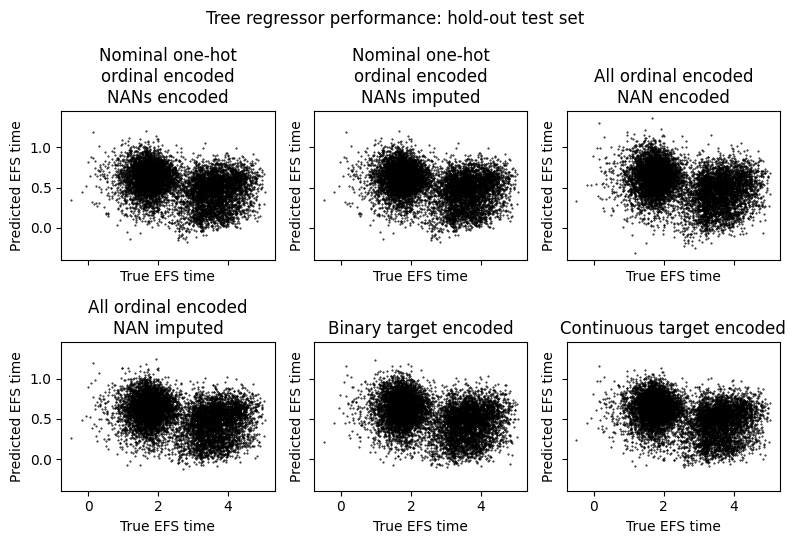

In [6]:
fig, axs=plt.subplots(2,3, figsize=(8,5.5), sharex=True, sharey=True)
axs=axs.flatten()

fig.suptitle('Tree regressor performance: hold-out test set')

for i, dataset in enumerate(regression_predictions.keys()):

    # Load the data
    data_file=datasets[dataset]

    with open(data_file, 'rb') as input_file:
        data_dict=pickle.load(input_file)

    axs[i].set_title(dataset.replace(', ', '\n').replace('/', '\n'))
    axs[i].scatter(
        np.log(data_dict['Testing labels']['efs_time'].values),
        regression_predictions[dataset],
        color='black',
        s=0.2
    )
    axs[i].set_xlabel('True EFS time')
    axs[i].set_ylabel('Predicted EFS time')

fig.tight_layout()
fig.savefig(regression_test_performance_plots, dpi=300, bbox_inches='tight')
fig.show()

#### 2.2.3. Residual plots

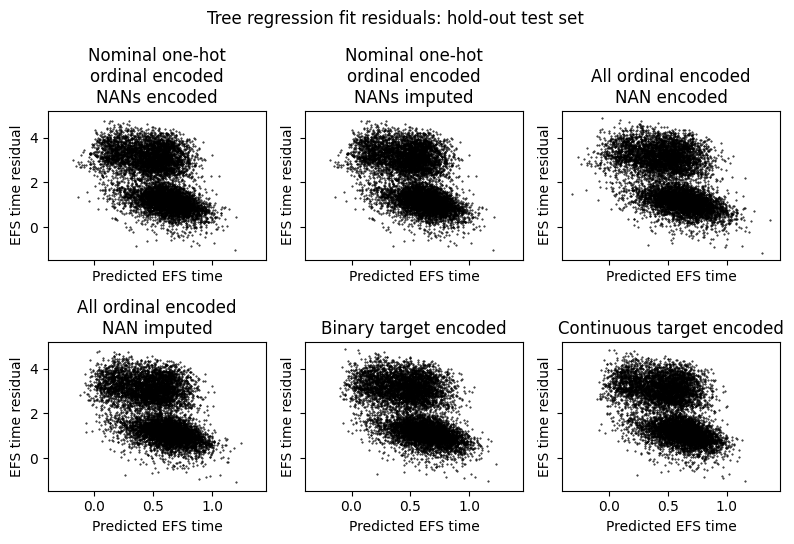

In [7]:
fig, axs=plt.subplots(2,3, figsize=(8,5.5), sharex=True, sharey=True)
axs=axs.flatten()

fig.suptitle('Tree regression fit residuals: hold-out test set')

for i, dataset in enumerate(regression_predictions.keys()):

    # Load the data
    data_file=datasets[dataset]

    with open(data_file, 'rb') as input_file:
        data_dict=pickle.load(input_file)

    axs[i].set_title(dataset.replace(', ', '\n').replace('/', '\n'))
    axs[i].scatter(
        regression_predictions[dataset],
        np.log(data_dict['Testing labels']['efs_time'].values) - regression_predictions[dataset],
        color='black',
        s=0.2
    )
    axs[i].set_xlabel('Predicted EFS time')
    axs[i].set_ylabel('EFS time residual')

fig.tight_layout()
fig.savefig(regression_test_residuals_plots, dpi=300, bbox_inches='tight')
fig.show()

## 3. Classification model

### 3.1. Hyperparameter optimization

In [8]:
if clustering_test == True:

    clustering_predictions={}
    clustering_models={}

    # Define cross-validation strategy
    cross_validation=ShuffleSplit(n_splits=10, test_size=0.3, random_state=315)

    # Loop on the datasets
    for dataset, data_file in datasets.items():

        # Load the data
        with open(data_file, 'rb') as input_file:
            data_dict=pickle.load(input_file)

        training_labels_df=data_dict['Training labels']
        training_features_df=data_dict['Training features']

        # Instantiate the model
        tree_model=HistGradientBoostingClassifier(random_state=315)

        # Set-up the search
        search=RandomizedSearchCV(
            tree_model,
            distributions,
            scoring='neg_root_mean_squared_error',
            n_jobs=cpus,
            cv=cross_validation,
            n_iter=randomsearch_depth,
            random_state=315,
            return_train_score=True
        )

        search_results=search.fit(training_features_df, training_labels_df['efs'])
        
        print(f'\n{dataset}:')
        for parameter, value in search_results.best_params_.items():
            print(f' {parameter}: {value}')

        # Train classifier with best hyperparameters on complete training set
        tree_model=HistGradientBoostingClassifier(**search_results.best_params_, random_state=315)
        result=tree_model.fit(training_features_df, training_labels_df['efs'])
        clustering_models[dataset]=tree_model

        # Make testing predictions
        testing_features_df=data_dict['Testing features']
        clustering_testing_predictions=tree_model.predict(testing_features_df)
        clustering_predictions[dataset]=clustering_testing_predictions

    clustering_test_results={'Testing predictions': clustering_predictions}
    clustering_test_results['Tuned models']=clustering_models

    with open(clustering_test_results_file, 'wb') as output_file:
        pickle.dump(clustering_test_results, output_file)

else:

    # Load last result
    with open(clustering_test_results_file, 'rb') as input_file:
        clustering_test_results=pickle.load(input_file)

    clustering_predictions=clustering_test_results['Testing predictions']
    clustering_models=clustering_test_results['Tuned models']


Nominal one-hot/ordinal encoded, NANs encoded:
 interaction_cst: no_interactions
 l2_regularization: 0.13962024338362589
 learning_rate: 0.7431320111128461
 max_bins: 36
 max_depth: 601
 max_features: 0.2610965600594495
 max_iter: 3758
 max_leaf_nodes: 495
 min_samples_leaf: 31

Nominal one-hot/ordinal encoded, NANs imputed:
 interaction_cst: no_interactions
 l2_regularization: 0.13962024338362589
 learning_rate: 0.7431320111128461
 max_bins: 36
 max_depth: 601
 max_features: 0.2610965600594495
 max_iter: 3758
 max_leaf_nodes: 495
 min_samples_leaf: 31

All ordinal encoded, NAN encoded:
 interaction_cst: pairwise
 l2_regularization: 0.18977515975085557
 learning_rate: 0.22897415791650066
 max_bins: 80
 max_depth: 545
 max_features: 0.3190366673490871
 max_iter: 1552
 max_leaf_nodes: 838
 min_samples_leaf: 196

All ordinal encoded, NAN imputed:
 interaction_cst: pairwise
 l2_regularization: 0.6852896625388644
 learning_rate: 0.16597519976277852
 max_bins: 20
 max_depth: 895
 max_featur

### 3.2. Results

#### 3.2.1. Confusion matrices

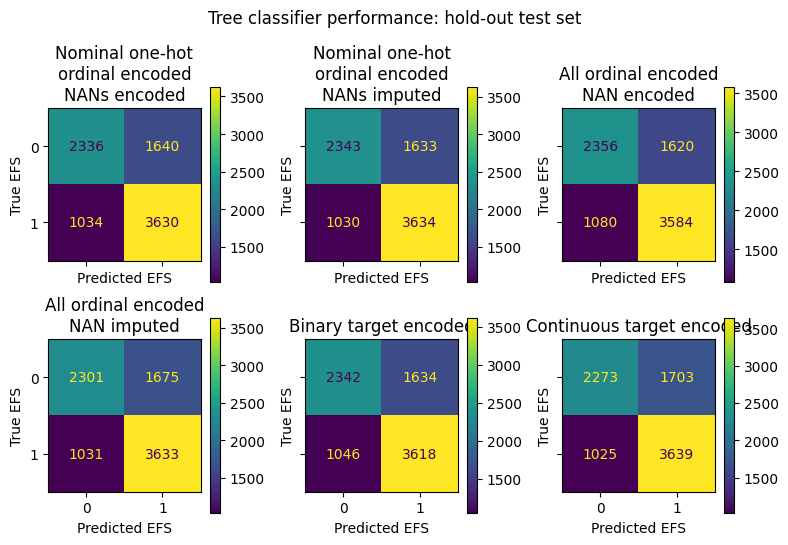

In [9]:
fig, axs=plt.subplots(2,3, figsize=(8,5.5), sharex=True, sharey=True)
axs=axs.flatten()

fig.suptitle('Tree classifier performance: hold-out test set')

for i, dataset in enumerate(clustering_predictions.keys()):

    # Load the data
    data_file=datasets[dataset]

    with open(data_file, 'rb') as input_file:
        data_dict=pickle.load(input_file)

    # Plot the confusion matrix
    cm=confusion_matrix(data_dict['Testing labels']['efs'], clustering_predictions[dataset])
    cm_disp=ConfusionMatrixDisplay(confusion_matrix=cm)
    _=cm_disp.plot(ax=axs[i])

    axs[i].set_title(dataset.replace(', ', '\n').replace('/', '\n'))
    axs[i].set_xlabel('Predicted EFS')
    axs[i].set_ylabel('True EFS')

fig.tight_layout()
fig.savefig(clustering_test_performance_plots, dpi=300, bbox_inches='tight')
fig.show()

#### 3.2.2. Class probabilities

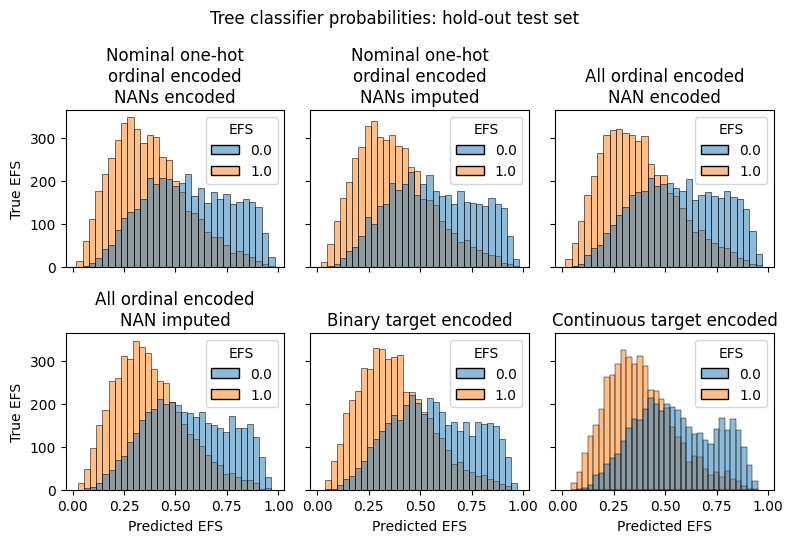

In [10]:
fig, axs=plt.subplots(2,3, figsize=(8,5.5), sharex=True, sharey=True)
axs=axs.flatten()

fig.suptitle('Tree classifier probabilities: hold-out test set')

for i, dataset in enumerate(clustering_predictions.keys()):

    # Load the data
    data_file=datasets[dataset]

    with open(data_file, 'rb') as input_file:
        data_dict=pickle.load(input_file)

    class_probabilities=clustering_models[dataset].predict_proba(data_dict['Testing features'])
    class_df=pd.DataFrame.from_dict({
        'EFS': data_dict['Testing labels']['efs'].values,
        'EFS probability': class_probabilities[:,0]
    })

    # Plot the confusion matrix
    sns.histplot(class_df, x='EFS probability', hue='EFS', ax=axs[i])

    axs[i].set_title(dataset.replace(', ', '\n').replace('/', '\n'))
    axs[i].set_xlabel('Predicted EFS')
    axs[i].set_ylabel('True EFS')

fig.tight_layout()
fig.savefig(clustering_test_probability_plots, dpi=300, bbox_inches='tight')
fig.show()